# Ramsey Numbers

#### Navigation
* [Graphs](./Graphs.ipynb)
* [Graphset Enumeration](./GraphsetEnumeration.ipynb)
* [Subgraph Isomorphism - Subgraph Search](./SubgraphIsomorphism.ipynb)

### Useful References

* [Ramsey's Theorem](https://en.wikipedia.org/wiki/Ramsey%27s_theorem)

### Problem

In [72]:
import time
from queue import LifoQueue
from copy import deepcopy

from graph import Graph

import polars as pl
import matplotlib.pyplot as plt

In [73]:
frame_schema = {
    "n": pl.UInt64,
    "F": pl.Object,
    "H": pl.Object,
    "expected_result": pl.Boolean,
    "linear_full_result": pl.Boolean,
    "tree_reduced_enumeration_result": pl.Boolean,
    "tree_search_result": pl.Boolean,
    "linear_full_time_ms": pl.Float64,
    "tree_reduced_enumeration_time_ms": pl.Float64,
    "tree_search_time_ms": pl.Float64
}

data = []
for n in range(3, 8):
    data.append([ n, Graph.complete_n(2), Graph.empty_n(2), True, None, None, None, 0., 0., 0. ])
    data.append([ n, Graph.complete_n(2), Graph.empty_n(3), True, None, None, None, 0., 0., 0. ])

    data.append([ n, Graph.complete_n(3), Graph.empty_n(3), n >= 6, None, None, None, 0., 0., 0. ])
    data.append([ n, Graph.complete_n(3), Graph.empty_n(4), n >= 9, None, None, None, 0., 0., 0. ])
    data.append([ n, Graph.complete_n(3), Graph.empty_n(5), n >= 14, None, None, None, 0., 0., 0. ])
    data.append([ n, Graph.complete_n(3), Graph.empty_n(6), n >= 18, None, None, None, 0., 0., 0. ])

    data.append([ n, Graph.complete_n(4), Graph.empty_n(4), n >= 18, None, None, None, 0., 0., 0. ])
    data.append([ n, Graph.complete_n(4), Graph.empty_n(5), n >= 25, None, None, None, 0., 0., 0. ])

upper_ramsey_data = pl.DataFrame(
    data=data,
    schema=frame_schema,
    orient="row"
)

upper_ramsey_data

n,F,H,expected_result,linear_full_result,tree_reduced_enumeration_result,tree_search_result,linear_full_time_ms,tree_reduced_enumeration_time_ms,tree_search_time_ms
u64,object,object,bool,bool,bool,bool,f64,f64,f64
3,1,0,true,null,null,null,0.0,0.0,0.0
3,111,000,false,null,null,null,0.0,0.0,0.0
3,111,000000,false,null,null,null,0.0,0.0,0.0
3,111,0000000000,false,null,null,null,0.0,0.0,0.0
4,1,0,true,null,null,null,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…
5,111,0000000000,false,null,null,null,0.0,0.0,0.0
6,1,0,true,null,null,null,0.0,0.0,0.0
6,111,000,true,null,null,null,0.0,0.0,0.0


In [74]:
def subgraph_search(G: Graph, H: Graph):
    """
        Decide if H is in G
            * return True if H in G
            * return False if H not in G
    """

    stack = LifoQueue()
    stack.put([])

    while not stack.empty():
        item = stack.get()

        if len(item) == H.properties.order:
            local_result = True
            for vert_a_H, vert_a_G in enumerate(item):
                for vert_b_H, vert_b_G in enumerate(item[vert_a_H + 1:]):
                    vert_b_H += vert_a_H + 1
                    if vert_a_G == vert_b_G or H[vert_a_H][vert_b_H] == -1:
                        continue

                    local_result = local_result and (G[vert_a_G][vert_b_G] == H[vert_a_H][vert_b_H])

            if local_result:
                return True
        else:
            for i in range((item[-1] + 1) if len(item) > 0 else 0, G.properties.order):
                new_item = deepcopy(item)
                new_item.append(i)
                stack.put(new_item)

    return False

In [75]:
def is_upper_ramsey_linear_full(n: int, F: Graph, H: Graph):
    result = True
    for i in range(0, int(2**(n*(n-1)/2))):
        G = Graph.from_id(i, n)
        result = result and (subgraph_search(G, F) or subgraph_search(G, H))

    return result

In [76]:
def is_upper_ramsey_tree_reduced_enumeration(n: int, F: Graph, H: Graph):
    stack = LifoQueue()
    result = True

    for i in range(n):
        new_item = []
        for _ in range(i):
            new_item.append("1")
        for _ in range(n - 1 - i):
            new_item.append("0")

        stack.put(new_item)

    while not stack.empty():
        item = stack.get()

        if len(item) < int(n*(n-1)/2):
            item_left_child = deepcopy(item)
            item_left_child.append('0')

            item_right_child = deepcopy(item)
            item_right_child.append('1')

            stack.put(item_right_child)
            stack.put(item_left_child)

        else:
            graph_id = int("".join(item), base=2)
            G = Graph.from_id(graph_id, n)
            result = result and (subgraph_search(G, F) or subgraph_search(G, H))

    return result


In [77]:
def is_upper_ramsey_tree_search(n: int, F: Graph, H: Graph):
    stack = LifoQueue()

    for i in range(n):
        new_item = []
        for _ in range(i):
            new_item.append("1")
        for _ in range(n - 1 - i):
            new_item.append("0")

        stack.put(new_item)

    while not stack.empty():
        item = stack.get()
        # print(item)
        current_G = Graph.from_bitstring("".join(item), n)
        # print("Testing\n", current_G.matrix, "\n", F.matrix, "\n", H.matrix, f"\n H in G ({subgraph_search(current_G, H)}), F in G ({subgraph_search(current_G, F)})")

        if len(item) < int(n*(n-1)/2):
            item_left_child = deepcopy(item)
            item_left_child.append('0')

            item_right_child = deepcopy(item)
            item_right_child.append('1')

            right_G = Graph.from_bitstring("".join(item_right_child), n)
            if not (subgraph_search(right_G, F) or subgraph_search(right_G, H)):
                stack.put(item_right_child)

            left_G = Graph.from_bitstring("".join(item_left_child), n)
            if not (subgraph_search(left_G, F) or subgraph_search(left_G, H)):
                stack.put(item_left_child)
        else:
            graph_id = int("".join(item), base=2)
            G = Graph.from_id(graph_id, n)
            if not(subgraph_search(G, F) or subgraph_search(G, H)):
                return False

    return True

In [78]:
# Testing Brute Force
test_data = []
for row in upper_ramsey_data.iter_rows(named=True):
    start_time = time.perf_counter()
    row['linear_full_result'] = is_upper_ramsey_linear_full(row['n'], row['F'], row['H'])
    end_time = time.perf_counter()
    row['linear_full_time_ms'] = (end_time - start_time) * 1000
    test_data.append(row)

upper_ramsey_data = pl.DataFrame(
    data=test_data,
    schema=frame_schema,
    orient="row"
)

In [79]:
# Testing Optimised A
test_data = []
for row in upper_ramsey_data.iter_rows(named=True):
    start_time = time.perf_counter()
    row['tree_reduced_enumeration_result'] = is_upper_ramsey_tree_reduced_enumeration(row['n'], row['F'], row['H'])
    end_time = time.perf_counter()
    row['tree_reduced_enumeration_time_ms'] = (end_time - start_time) * 1000
    test_data.append(row)

upper_ramsey_data = pl.DataFrame(
    data=test_data,
    schema=frame_schema,
    orient="row"
)

In [80]:
# Testing Optimised B
test_data = []
for row in upper_ramsey_data.iter_rows(named=True):
    start_time = time.perf_counter()
    row['tree_search_result'] = is_upper_ramsey_tree_search(row['n'], row['F'], row['H'])
    end_time = time.perf_counter()
    row['tree_search_time_ms'] = (end_time - start_time) * 1000
    test_data.append(row)

upper_ramsey_data = pl.DataFrame(
    data=test_data,
    schema=frame_schema,
    orient="row"
)

In [81]:
upper_ramsey_data

n,F,H,expected_result,linear_full_result,tree_reduced_enumeration_result,tree_search_result,linear_full_time_ms,tree_reduced_enumeration_time_ms,tree_search_time_ms
u64,object,object,bool,bool,bool,bool,f64,f64,f64
3,1,0,true,true,true,true,1.8926,1.2698,2.1382
3,111,000,false,false,false,false,0.9675,0.6815,1.5359
3,111,000000,false,false,false,false,1.2972,0.6557,1.1749
3,111,0000000000,false,false,false,false,0.5738,0.5073,0.891
4,1,0,true,true,true,true,13.1349,4.4238,1.4493
…,…,…,…,…,…,…,…,…,…
5,111,0000000000,false,false,false,false,90.3304,39.1304,7.4566
6,1,0,true,true,true,true,6434.3022,1201.1704,2.5077
6,111,000,true,true,true,true,12723.994,2650.1929,52.7863


#### Runtime Graphs

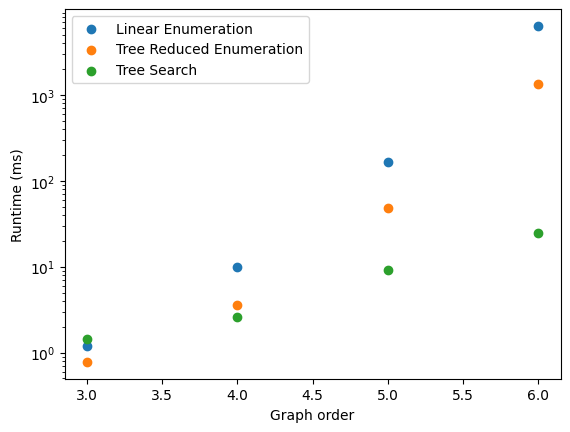

In [82]:
performance_data = upper_ramsey_data.group_by("n").agg(
    pl.col("linear_full_time_ms").mean(), 
    pl.col("tree_reduced_enumeration_time_ms").mean(),
    pl.col("tree_search_time_ms").mean()
)

plt.scatter(
    x=performance_data["n"],
    y=performance_data["linear_full_time_ms"],
    label="Linear Enumeration"
)

plt.scatter(
    x=performance_data["n"],
    y=performance_data["tree_reduced_enumeration_time_ms"],
    label="Tree Reduced Enumeration"
)

plt.scatter(
    x=performance_data["n"],
    y=performance_data["tree_search_time_ms"],
    label="Tree Search"
)

plt.ylabel("Runtime (ms)")
plt.yscale('log')
plt.xlabel("Graph order")
plt.legend(loc="upper left")
plt.show()

In [83]:
# Convert subgraph objects to string
new_F = upper_ramsey_data.select(["F"]).get_columns()[0].map_elements(lambda G: G.to_bitstring(), return_dtype=pl.String)
new_H = upper_ramsey_data.select(["H"]).get_columns()[0].map_elements(lambda G: G.to_bitstring(), return_dtype=pl.String)
upper_ramsey_data = upper_ramsey_data.with_columns(F = new_F)
upper_ramsey_data = upper_ramsey_data.with_columns(H = new_H)

upper_ramsey_data.write_csv("./data/upper_ramsey.csv")
upper_ramsey_data

n,F,H,expected_result,linear_full_result,tree_reduced_enumeration_result,tree_search_result,linear_full_time_ms,tree_reduced_enumeration_time_ms,tree_search_time_ms
u64,str,str,bool,bool,bool,bool,f64,f64,f64
3,"""1""","""0""",true,true,true,true,1.8926,1.2698,2.1382
3,"""111""","""000""",false,false,false,false,0.9675,0.6815,1.5359
3,"""111""","""000000""",false,false,false,false,1.2972,0.6557,1.1749
3,"""111""","""0000000000""",false,false,false,false,0.5738,0.5073,0.891
4,"""1""","""0""",true,true,true,true,13.1349,4.4238,1.4493
…,…,…,…,…,…,…,…,…,…
5,"""111""","""0000000000""",false,false,false,false,90.3304,39.1304,7.4566
6,"""1""","""0""",true,true,true,true,6434.3022,1201.1704,2.5077
6,"""111""","""000""",true,true,true,true,12723.994,2650.1929,52.7863
